# Final Project
### Team: Data Miner(Weirong He, Michael Gainey, Tri Pham)
### Topic: Taxi Data Analysis

In [27]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np
import pyarrow.parquet as pq
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import joblib

In [2]:
sc = SparkContext()
session = SparkSession(sc)

21/12/07 12:29:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Data Process
Data set could be download at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
In this project, we are focusing on year 2020, so we have 12 month taxi data in 2020. However, this dataset is too large for this project, so we decide to only take data at the first week of each month which will lead to result of 5M records.

In [3]:
taxi_record_1 = session.read.csv("data/records/yellow_tripdata_2020-01.csv", header=True)
taxi_record_2 = session.read.csv("data/records/yellow_tripdata_2020-02.csv", header=True)
taxi_record_3 = session.read.csv("data/records/yellow_tripdata_2020-03.csv", header=True)
taxi_record_4 = session.read.csv("data/records/yellow_tripdata_2020-04.csv", header=True)
taxi_record_5 = session.read.csv("data/records/yellow_tripdata_2020-05.csv", header=True)
taxi_record_6 = session.read.csv("data/records/yellow_tripdata_2020-06.csv", header=True)
taxi_record_7 = session.read.csv("data/records/yellow_tripdata_2020-07.csv", header=True)
taxi_record_8 = session.read.csv("data/records/yellow_tripdata_2020-08.csv", header=True)
taxi_record_9 = session.read.csv("data/records/yellow_tripdata_2020-09.csv", header=True)
taxi_record_10 = session.read.csv("data/records/yellow_tripdata_2020-10.csv", header=True)
taxi_record_11 = session.read.csv("data/records/yellow_tripdata_2020-11.csv", header=True)
taxi_record_12 = session.read.csv("data/records/yellow_tripdata_2020-12.csv", header=True)
location_df = session.read.csv("data/taxi+_zone_lookup.csv", header=True)

In [4]:
dates = ("2020-01-01",  "2020-01-07")
taxi_record_1 = taxi_record_1.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-02-01",  "2020-02-07")
taxi_record_2 = taxi_record_2.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-03-01",  "2020-03-07")
taxi_record_3 = taxi_record_3.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-04-01",  "2020-04-07")
taxi_record_4 = taxi_record_4.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-05-01",  "2020-05-07")
taxi_record_5 = taxi_record_5.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-06-01",  "2020-06-07")
taxi_record_6 = taxi_record_6.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-07-01",  "2020-07-07")
taxi_record_7 = taxi_record_7.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-08-01",  "2020-08-07")
taxi_record_8 = taxi_record_8.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-09-01",  "2020-09-07")
taxi_record_9 = taxi_record_9.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-10-01",  "2020-10-07")
taxi_record_10 = taxi_record_10.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-11-01",  "2020-11-07")
taxi_record_11 = taxi_record_11.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-12-01",  "2020-12-07")
taxi_record_12 = taxi_record_12.where(F.col('tpep_pickup_datetime').between(*dates))

In [5]:
taxi_record = (taxi_record_1.union(taxi_record_2).union(taxi_record_3)
               .union(taxi_record_4).union(taxi_record_5).union(taxi_record_6)
               .union(taxi_record_7).union(taxi_record_8).union(taxi_record_9)
               .union(taxi_record_10).union(taxi_record_11).union(taxi_record_12)
               .drop("VendorID", "RatecodeID", "payment_type", "store_and_fwd_flag",
                     "improvement_surcharge", "mta_tax", "tolls_amount", "congestion_surcharge")
              )
taxi_record = (taxi_record.withColumn('trip_distance', F.col("trip_distance").cast("float"))
               .withColumn('tpep_pickup_datetime', F.to_timestamp(F.col('tpep_pickup_datetime')))
               .withColumn('tpep_dropoff_datetime', F.to_timestamp(F.col('tpep_dropoff_datetime')))
               .withColumn('passenger_count', F.col("passenger_count").cast("int"))
               .withColumn('PULocationID', F.col("PULocationID").cast("int"))
               .withColumn('DOLocationID', F.col("DOLocationID").cast("int"))
               .withColumn('fare_amount', F.col("fare_amount").cast("float"))
               .withColumn('extra', F.col("extra").cast("float"))
               .withColumn('tip_amount', F.col("tip_amount").cast("float"))
               .withColumn('total_amount', F.col("total_amount").cast("float"))
               .withColumn('trip_distance', F.col("trip_distance").cast("float")))

In [6]:
taxi_record.head()

Row(tpep_pickup_datetime=datetime.datetime(2020, 1, 1, 0, 28, 15), tpep_dropoff_datetime=datetime.datetime(2020, 1, 1, 0, 33, 3), passenger_count=1, trip_distance=1.2000000476837158, PULocationID=238, DOLocationID=239, fare_amount=6.0, extra=3.0, tip_amount=1.4700000286102295, total_amount=11.270000457763672)

## Visualization

### Activities
First thing we interested in taxi report dataset is activities. We want to see what is the time period that has most taxi pick up activities. Therefore, we decided to analyze activities per hour, day of week, and month.

In [7]:
hour_count = (taxi_record.select(F.hour('tpep_pickup_datetime').alias('hour'))
                   .groupby('hour').count())
dayOfWeek_count = (taxi_record.select(F.dayofweek('tpep_pickup_datetime').alias('weekOfDay'))
                   .groupby('weekOfDay').count())
month_count = (taxi_record.select(F.month('tpep_pickup_datetime').alias('month'))
                   .groupby('month').count())

df_hour = hour_count.toPandas()


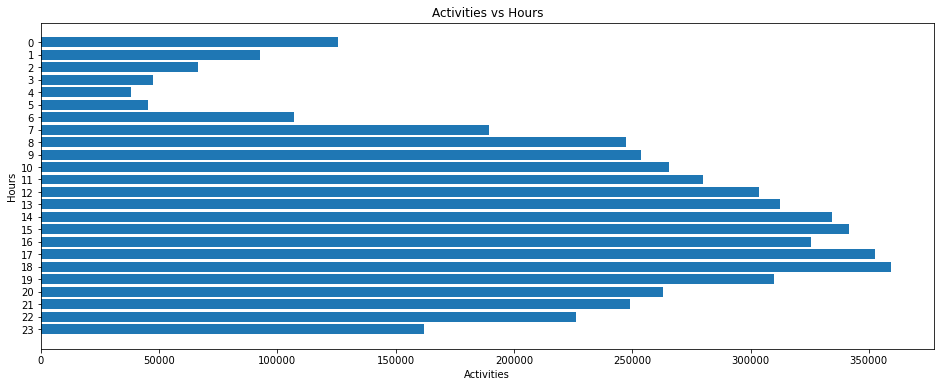

In [8]:
df_hour = df_hour.sort_values(by=['hour'])
hour_counts = np.array(df_hour['count']).astype(int)
hours = np.array(df_hour['hour'])
plt.figure(figsize=(16,6))
plt.barh(hours, hour_counts)
plt.yticks(range(0, 24))
plt.gca().invert_yaxis()
plt.xlabel("Activities")
plt.ylabel("Hours")
plt.title("Activities vs Hours")
plt.show()

From the bar graph above, we can see that busy peroid for taxi is afternoon from 1pm to 7pm. In addition, time before dawn has fewer pick up activities.

In [9]:
df_dayOfWeek = dayOfWeek_count.toPandas()
df_month = month_count.toPandas()

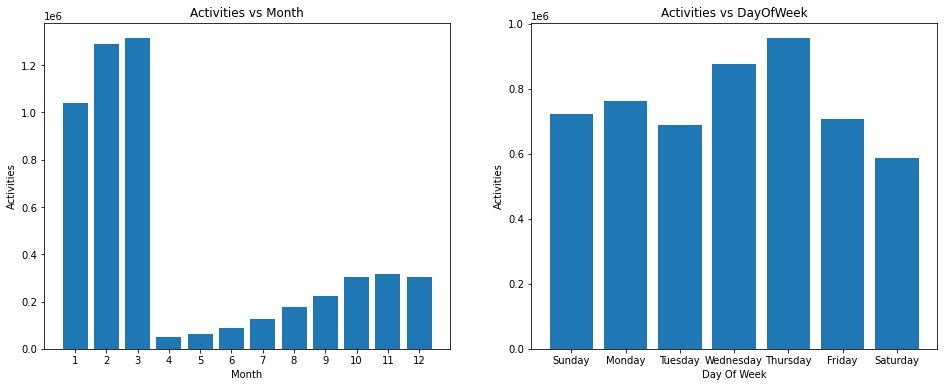

In [10]:
df_month = df_month.sort_values(by=['month'])
month_counts = np.array(df_month['count']).astype(int)
months = np.array(df_month['month'])

df_dayOfWeek = df_dayOfWeek.sort_values(by=['weekOfDay'])
dow_counts = np.array(df_dayOfWeek['count']).astype(int)
# weekOfDay 1=Sunday, 2=Monday...
dow = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].bar(months, month_counts)
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Activities")
axes[0].set_title("Activities vs Month")

axes[1].bar(dow, dow_counts)
axes[1].set_xlabel("Day Of Week")
axes[1].set_ylabel("Activities")
axes[1].set_title("Activities vs DayOfWeek")
plt.show()

From the Activities vs Month graph on left, we can see that there are lots of taxi activities from January to March. However, start from April, taxi activities count became extremely low. It is because of the lock down in NewYork due to the pandemic.

From the the Activities vs Day of Week graph, we can know the most busy day is Thursday, and Saturday has least activities which make sense since Saturday is the first day of weekend, most people like to stay at home to have a rest in Saturday.

### Trip Duration
The other thing we want to analyze is trip duration (drop off time - pick up time). We worked on find the relationship between trip duration and pick up time (average duration vs hours).

In [11]:
taxi_record.select(F.col('tpep_dropoff_datetime'))
recordWithDuration = taxi_record.withColumn('trip_duration',
              F.col("tpep_dropoff_datetime").cast("long") - F.col('tpep_pickup_datetime').cast("long"))
recordWithDuration = recordWithDuration.select(F.hour('tpep_pickup_datetime').alias('pickup_hour'),
                                               F.col('trip_duration'))
df_tripDurationVSPickupTime = (recordWithDuration.groupby('pickup_hour')
                               .avg('trip_duration')
                               .sort(F.col('pickup_hour'))
                               .toPandas())

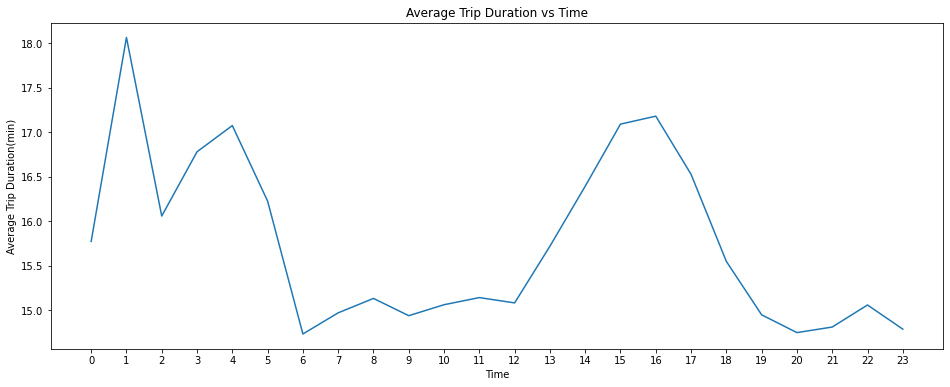

In [12]:
trip_durations = np.array(df_tripDurationVSPickupTime['avg(trip_duration)'])/60
hours = np.array(df_tripDurationVSPickupTime['pickup_hour'])
plt.figure(figsize=(16,6))
plt.plot(hours, trip_durations)
plt.xticks(range(0, 24))
plt.xlabel("Time")
plt.ylabel("Average Trip Duration(min)")
plt.title("Average Trip Duration vs Time")
plt.show()

### Location
We also want to know which area is the best pick up location for taxi driver. So we have the heat map to see the amount of taxi pickup activities in NewYork city areas.

In [13]:
# Activities vs location

### Profit
For taxi drivers, of course the most important thing is money. We want to know the relation of fareamount and pickup location, and the relation of money and pickup time (tips/time, total_fare/time, extras/time). In addition, we also want to know whether short trips that cover a long distance or long one where one is tuck in traffic are more profitable. 

In [ ]:
# Profit vs location

In [14]:
recordWithDuration = taxi_record.withColumn('trip_duration',
              F.col("tpep_dropoff_datetime").cast("long") - F.col('tpep_pickup_datetime').cast("long"))
money_time = recordWithDuration.select(F.col('fare_amount')
                                       , F.col('extra').cast('long')
                                       , F.col('tip_amount')
                                       , F.hour('tpep_pickup_datetime').alias('hour'))
df_moneyVSTime = (money_time.groupby('hour')
                  .agg(F.avg("extra"), F.avg('tip_amount'), F.avg('fare_amount'))
                  .sort(F.col('hour'))
                  .toPandas())

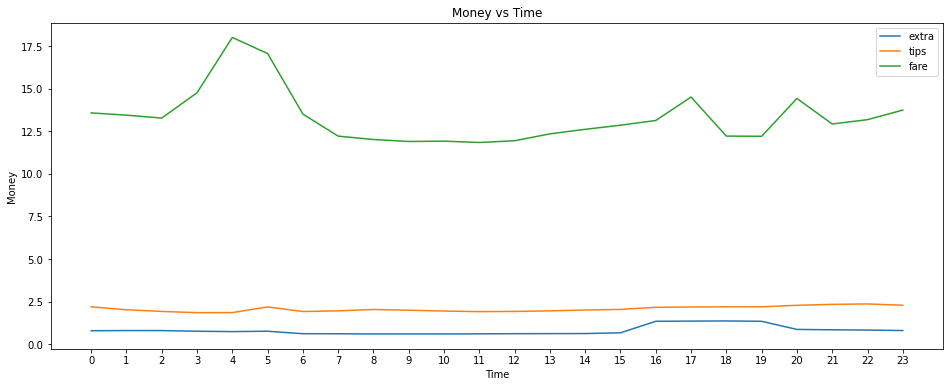

In [15]:
avg_extra = np.array(df_moneyVSTime['avg(extra)'])
avg_tip = np.array(df_moneyVSTime['avg(tip_amount)'])
avg_fare = np.array(df_moneyVSTime['avg(fare_amount)'])
hours = np.array(df_moneyVSTime['hour'])
plt.figure(figsize=(16,6))
plt.plot(hours, avg_extra, label='extra')
plt.plot(hours, avg_tip, label='tips')
plt.plot(hours, avg_fare, label='fare')
plt.xticks(range(0, 24))
plt.xlabel("Time")
plt.ylabel("Money")
plt.title("Money vs Time")
plt.legend()
plt.show()

In [ ]:
dist_time_price = recordWithDuration.select(F.col('trip_distance'), F.col('trip_duration'), F.col('fare_amount'))

# # save spark df
dist_time_price.write.mode("overwrite").parquet("dist_time_price.parquet")
# # load into pandas df
dist_time_price_df = pq.read_pandas('dist_time_price.parquet').to_pandas()

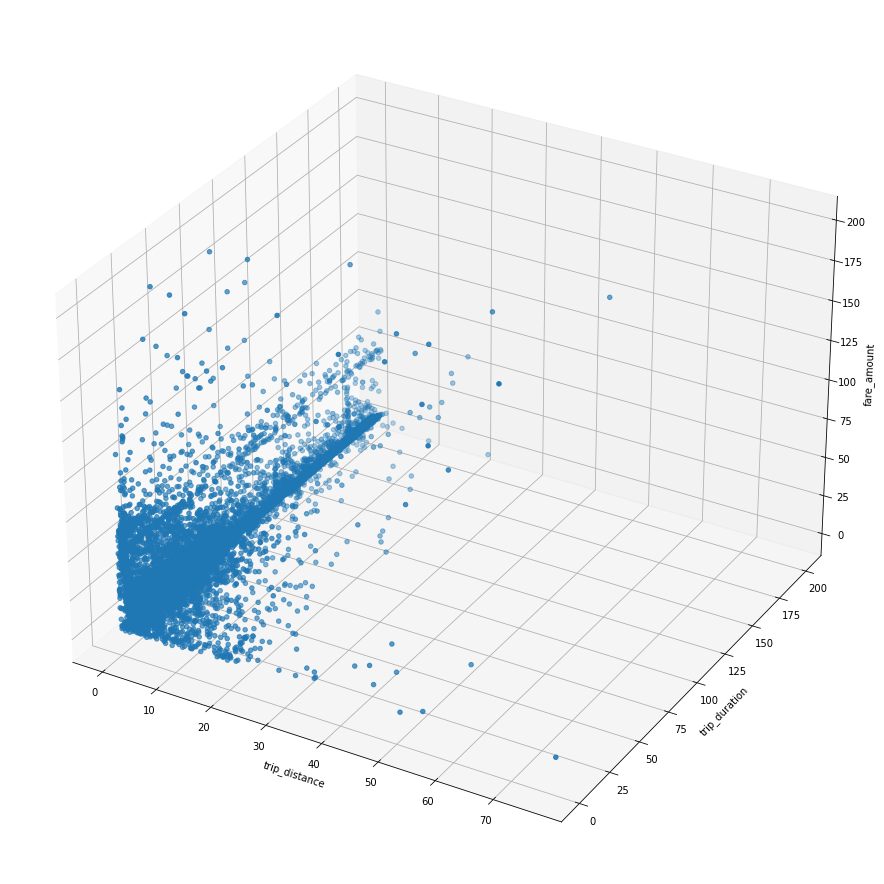

In [47]:
dist_time_price_df[dist_time_price_df < 0] = None
# there are a little extremely high number records which not help visualization
dist_time_price_df[dist_time_price_df > 200] = None
dist_time_price_df = dist_time_price_df.dropna()
X = np.array(dist_time_price_df['trip_distance'])
Y = np.array(dist_time_price_df['trip_duration'])
Z = np.array(dist_time_price_df['fare_amount'])

fig = plt.figure(figsize=(16, 16))
# Create 3D container
ax = plt.axes(projection = '3d')
# Visualize 3D scatter plot
ax.scatter3D(X, Y, Z)
# Give labels
ax.set_xlabel('trip_distance')
ax.set_ylabel('trip_duration')
ax.set_zlabel('fare_amount')
plt.show();

From the 3d graph above about Fare amount vs (trip distance and trip duration), we can see that time duration of trips didn't have significant effect on the fare amoiunt price.

## Machine Learning
We can use Machine Learning to help taxi driver to predict the fare amout of next trip. In real life, taxi passengers alway like to ask the price right after they stating the destination location. Many drivers with more experience can quickly response a rough price. And this model can look through 5M trips to become a experienced taxi driver and make a prediction of the fare amount based on the pickup location and drop off location.

In [ ]:
# data process in spark
loc_price = taxi_record.select(F.col("PULocationID").alias("PU"),
                   F.col("DOLocationID").alias("DO"),
                   F.col("fare_amount").alias("Price"))
# filter null value record and unknown record(locationID: 264 and 265 are unknown)
loc_price = loc_price.filter(loc_price.PU.isNotNull() & loc_price.PU.between(1, 263)
                             & loc_price.DO.isNotNull() & loc_price.DO.between(1, 263)
                             & loc_price.Price.isNotNull())

In [ ]:
%%time
# convert spark df to pandas df using parquet. Uncomment next line if need reload

# loc_price.write.mode("overwrite").parquet("loc_price.parquet")

# load into pandas df
pd_df = pq.read_pandas('loc_price.parquet').to_pandas()

In [ ]:
# data process in pandas df
pickup = np.array(pd_df.PU).astype(float)
dropoff = np.array(pd_df.DO).astype(float)

location = np.vstack((pickup, dropoff)).T
price = np.array(pd_df.Price).astype(float)
# data split
X_train, X_test, y_train, y_test = train_test_split(location, price, test_size=0.2)

##### Training model may takes 4 min, we also save the model as a file `trained_model.sav`. Therefore we can skip this cell and just run next cell to load the saved model.

In [ ]:
# %%time
# # train the model
# regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

# # save model to disk
# filename = 'trained_model.sav'
# joblib.dump(regr, filename)

In [ ]:
filename = 'trained_model.sav'
trained_model = joblib.load(filename)
y_pred = trained_model.predict(X_test)

In [ ]:
def cal_accuracy(pred, actual):
    count = 0;
    for i in range(len(actual)):
        if (abs(pred[i] - actual[i]) <= 7):
            count = count + 1
    accuracy = count/len(actual)
    return accuracy
print("price accuracy(accept +- 7 error) : %.2f" %cal_accuracy(y_pred, y_test))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

In [ ]:
def on_button_clicked(b):
    with output:
        output.clear_output()
        price = trained_model.predict([[d1.value, d2.value]])
        price_format = "{:.5f}".format(price[0])
        print(f"Predict Price = ${price_format}")
# dropdown options list
loc_df = pd.read_csv("data/taxi+_zone_lookup.csv")
loc_dict = dict(zip(loc_df.LocationID, loc_df.Borough + " " + loc_df.Zone))
loc_options = []
for key, value in loc_dict.items():
    loc_options.append((value, key))
# remove two element unknown and nan
_ = loc_options.pop()
_ = loc_options.pop()        

d1 = widgets.Dropdown(
    options=loc_options,
    value=1,
    description='From:',
)
d2 = widgets.Dropdown(
    options=loc_options,
    value=1,
    description='To:',
)
button = widgets.Button(description="Calculate")
button.on_click(on_button_clicked)

output = widgets.Output()

items = [d1, d2, button, output]
box = widgets.Box(children=items)
display(box)